<a href="https://colab.research.google.com/github/jnsbrdbr/andrew-ng/blob/master/logesticregressionthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.7.0


In [2]:
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from decimal import Decimal
from math import*

from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA

from sklearn.metrics import pairwise_distances

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
%matplotlib inline

In [3]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import sys, os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#from google.colab import drive
#drive.flush_and_unmount()

In [6]:
path = "/content/drive/MyDrive/test/test10.csv"
#path = "/content/drive/MyDrive/Tmp/test/test10.csv"
data = pd.read_csv(path)

In [7]:
type(data)

pandas.core.frame.DataFrame

part 1

In [8]:
data

,src,dst
0,1,2
1,1,4
2,3,4
3,3,5
4,5,6
5,5,10
6,5,12
7,5,14


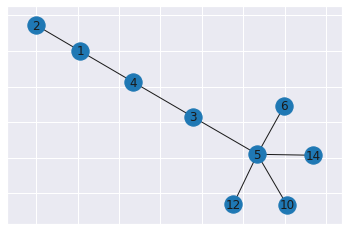

In [9]:
import networkx as nx
g = nx.from_pandas_edgelist(data, "src","dst")
nx.draw_networkx(g)

adjucency matrix

In [10]:
#adjucency matrix without chunking
adjc = pd.crosstab(data.src, data.dst)
idx = adjc.columns.union(adjc.index)
up_adj_mtx = adjc.reindex(index = idx, columns=idx, fill_value=0)


In [11]:
#print(up_adj_mtx)

In [12]:
adj_mtx_df=up_adj_mtx
for i in adj_mtx_df:
  for j in adj_mtx_df:
    if(adj_mtx_df[i][j]!=0):
       adj_mtx_df[j][i]=adj_mtx_df[i][j]

adj_mtx_df

,1,2,3,4,5,6,10,12,14
1,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0
4,1,0,1,0,0,0,0,0,0
5,0,0,1,0,0,1,1,1,1
6,0,0,0,0,1,0,0,0,0
10,0,0,0,0,1,0,0,0,0
12,0,0,0,0,1,0,0,0,0
14,0,0,0,0,1,0,0,0,0


In [13]:
adj_mtx=adj_mtx_df.to_numpy()
print(adj_mtx)

[[0 1 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 1 1 1 1]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]]


In [14]:
#adjucency matrix with chunking

#for data in pd.read_csv(path, chunksize=2):
#    print (data)
#    data1 = pd.crosstab(data.src, data.dst)
#    idx = data1.columns.union(data1.index)
#    data2 = data1.reindex(index = idx, columns=idx, fill_value=0)
#    print(data2)

part2

common firend(CF):one of the measure for similarity in social networks is the number of firends,shared.given the sicial network G and two nodes u and v all vertics that are on a path wih the length of two between these two nodes are common firends of the nodes.
در مربع ماتریس مجاورت درایه"آی جی ام"و غیر واقع بر قطر اصلی مربع ماتریس مجاورت نشان دهنده تعدا مسیر به طول دو بین دو راس آی و جی هست

In [15]:
#common firend

CF=np.dot(adj_mtx,adj_mtx) #matrix multiplication
#print(CF,'\n')

CF=CF - np.diag(np.diag(CF))#matrix off_diagonal
#print(CF)

In [16]:
#total_firend

adjc = pd.crosstab(data.src, data.dst)
idx = adjc.columns.union(adjc.index)
up_adj_mtx = adjc.reindex(index = idx, columns=idx, fill_value=0)
up_adj_mtx=up_adj_mtx.to_numpy()
#print(up_adj_mtx)

In [17]:
i=up_adj_mtx.shape[0]
c=np.zeros(shape=(i,i))
for i in range(0,up_adj_mtx.shape[0]):
  for j in range(0,up_adj_mtx.shape[1]):
     if i==j:
       c[i,j]=(sum(up_adj_mtx[i,:])+sum(up_adj_mtx[:,j]))
#print(c)

In [18]:
i=c.shape[0]
TF=np.zeros(shape=(i,i))
for i in range(0,c.shape[0]):
  for j in range(0,c.shape[1]):
    TF[i,j]=c[i,i]+c[j,j]
TF=TF - np.diag(np.diag(TF))#matrix off_diagonal
#print(TF)

In [19]:
#jaccard_similarity

i=adj_mtx.shape[0]
jaccard_similarity=np.zeros(shape=(i,i))
for i in range(0,jaccard_similarity.shape[0]):
  for j in range(0,jaccard_similarity.shape[1]):
    if CF[i,j]==0 or TF[i,j]==0:
       jaccard_similarity[i,j]==0
    else:
       #jaccard_similarity[i,j]=(CF[i,j]/TF[i,j])
       jaccard_similarity[i,j]=np.divide(CF[i,j],TF[i,j])
       jaccard_similarity=np.round(jaccard_similarity,2)

jaccard_similarity=jaccard_similarity - np.diag(np.diag(jaccard_similarity))#matrix off_diagonal
#print(jaccard_similarity)


In [20]:
#cosine_similarity

i=up_adj_mtx.shape[0]
cosine_similarity1=np.zeros(shape=(i,i))
for i in range(0,cosine_similarity1.shape[0]):
  for j in range(0,cosine_similarity1.shape[1]):
       cosine_similarity1[i,j]=sqrt((c[i,i])*(c[j,j]))

#print(cosine_similarity1)

In [21]:
i=adj_mtx.shape[0]
cosine_similarity=np.zeros(shape=(i,i))
for i in range(0,cosine_similarity.shape[0]):
  for j in range(0,cosine_similarity.shape[1]):
    if CF[i,j]==0 or cosine_similarity1[i,j]==0:
       cosine_similarity[i,j]==0
    else:
       cosine_similarity[i,j]=np.divide(CF[i,j],cosine_similarity1[i,j])
       cosine_similarity=np.round(cosine_similarity,2)

cosine_similarity=cosine_similarity - np.diag(np.diag(cosine_similarity))#matrix off_diagonal
#print(cosine_similarity)

In [22]:
cosine_similarity = pairwise_distances(up_adj_mtx, metric='cosine')
#print(cosine_similarity)

In [23]:
#L1_norm()
 
i=up_adj_mtx.shape[0]
L1_norm1=np.zeros(shape=(i,i))
for i in range(0,L1_norm1.shape[0]):
  for j in range(0,L1_norm1.shape[1]):
       L1_norm1[i,j]=(c[i,i])*(c[j,j])

#print(L1_norm1)

In [24]:
i=adj_mtx.shape[0]
L1_norm=np.zeros(shape=(i,i))
for i in range(0,L1_norm.shape[0]):
  for j in range(0,L1_norm.shape[1]):
    if CF[i,j]==0 or L1_norm1[i,j]==0:
       L1_norm[i,j]==0
    else:
       #jaccard_similarity[i,j]=(CF[i,j]/TF[i,j])
       L1_norm[i,j]=np.divide(CF[i,j],L1_norm1[i,j])
       L1_norm=np.round(L1_norm,2)

L1_norm=L1_norm - np.diag(np.diag(L1_norm))#matrix off_diagonal
#print(L1_norm)

In [25]:
#edge_weight_measure

i=up_adj_mtx.shape[0]
ewm=np.zeros(shape=(i,i))
for i in range(0,ewm.shape[0]):
  for j in range(0,ewm.shape[1]):
     if i==j:
       ewm[i,j]=1/sqrt(1+c[i,i])
       ewm=np.round(ewm)

#print(ewm)

In [26]:
i=up_adj_mtx.shape[0]
wsum=np.zeros(shape=(i,i))
for i in range(0,wsum.shape[0]):
  for j in range(0,wsum.shape[1]):
    wsum[i,j]=ewm[i,i]+ewm[j,j]
    #wsum=np.round(wsum)
#print(wsum)

In [27]:
i=up_adj_mtx.shape[0]
wmul=np.zeros(shape=(i,i))
for i in range(0,wmul.shape[0]):
  for j in range(0,wmul.shape[1]):
    wmul[i,j]=ewm[i,i]*ewm[j,j]
    wmul=np.round(wmul,2)
#print(wmul)

data_label

[link text](https://)# Fake nodes (Users) = 0
# Read nodes = 1

In [28]:
path_label = "/content/drive/MyDrive/test/label_test10_10.csv"
#path_label = "/content/drive/MyDrive/Tmp/jinus_data/test/label_test10_10.csv"
data_label = pd.read_csv(path_label)

In [29]:
type(data_label)

pandas.core.frame.DataFrame

In [30]:
adjList=list(adj_mtx_df.columns)
print(adjList)

[1, 2, 3, 4, 5, 6, 10, 12, 14]


In [31]:
labelList=list(data_label['id'])
print(labelList)

[1, 5, 6]


In [32]:
def elm_exists(list_little, list_big):
    result=[]
    for elm in list_big:
        if elm in list_little:
            result.append(1)
        else:
            result.append(0)
    return result


In [33]:
res=elm_exists(labelList,adjList)
print(res)

[1, 0, 0, 0, 1, 1, 0, 0, 0]


In [34]:
adj_mtx_df['label']=res
print(adj_mtx_df)

    1  2  3  4  5  6  10  12  14  label
1   0  1  0  1  0  0   0   0   0      1
2   1  0  0  0  0  0   0   0   0      0
3   0  0  0  1  1  0   0   0   0      0
4   1  0  1  0  0  0   0   0   0      0
5   0  0  1  0  0  1   1   1   1      1
6   0  0  0  0  1  0   0   0   0      1
10  0  0  0  0  1  0   0   0   0      0
12  0  0  0  0  1  0   0   0   0      0
14  0  0  0  0  1  0   0   0   0      0


In [35]:
#col_data_label=(data_label[:,1])
#print(col_data_label)

In [36]:
#fin_data_label=CF_label.reshape(-1,1)


SMOTE:Synthetic Minority Oversampling TEchnique

In [37]:
#CF
oversample1 = SMOTE(k_neighbors=2)
CF_smote,CF_label= oversample1.fit_resample(CF,adj_mtx_df['label'])

In [38]:
type(CF_label)

pandas.core.series.Series

In [39]:
print(CF_label)

0     1
1     0
2     0
3     0
4     1
5     1
6     0
7     0
8     0
9     1
10    1
11    1
Name: label, dtype: int64


In [40]:
#TF
oversample2 = SMOTE(k_neighbors=2)
TF_smote,TF_label= oversample2.fit_resample(TF,adj_mtx_df['label'])

In [41]:
print(TF_label)

0     1
1     0
2     0
3     0
4     1
5     1
6     0
7     0
8     0
9     1
10    1
11    1
Name: label, dtype: int64


In [42]:
#jaccard_similarity
oversample3 = SMOTE(k_neighbors=2)
jaccard_similarity_smote,jaccard_similarity_label= oversample3.fit_resample(jaccard_similarity,
                                                                            adj_mtx_df['label'])

In [43]:
#cosine_similarity
oversample4 = SMOTE(k_neighbors=2)
cosine_similarity_smote,cosine_similarity_label= oversample4.fit_resample(cosine_similarity,
                                                                          adj_mtx_df['label'])

In [44]:
#L1_norm
oversample5 = SMOTE(k_neighbors=2)
L1_norm_smote,L1_norm_label= oversample5.fit_resample(L1_norm,adj_mtx_df['label'])

In [45]:
#wsum
oversample6 = SMOTE(k_neighbors=2)
wsum_smote,wsum_label= oversample6.fit_resample(wsum,adj_mtx_df['label'])

In [46]:
#wmul
oversample7 = SMOTE(k_neighbors=2)
wmul_smote,wmul_label= oversample7.fit_resample(wmul,adj_mtx_df['label'])

PCA

In [47]:

pca = PCA(n_components=2)
CF_pca = pca.fit_transform(CF_smote)
#principalDf = pd.DataFrame(data = principalComponents)
print(np.round(CF_pca))

[[-0. -1.]
 [-1.  0.]
 [ 1.  1.]
 [-1.  0.]
 [-1.  0.]
 [ 1. -0.]
 [ 1. -0.]
 [ 1. -0.]
 [ 1. -0.]
 [-0. -1.]
 [-1.  0.]
 [-1.  0.]]


In [48]:
pca = PCA(n_components=2)
TF_pca = pca.fit_transform(TF_smote)
#principalDf = pd.DataFrame(data = principalComponents)
print(np.round(TF_pca))

[[-1.  0.]
 [-2. -1.]
 [-1.  3.]
 [-1.  3.]
 [11. -0.]
 [-2. -1.]
 [-2. -1.]
 [-2. -1.]
 [-2. -1.]
 [-2. -1.]
 [ 7. -1.]
 [-2. -1.]]


In [49]:
pca = PCA(n_components=2)
jaccard_similarity_pca = pca.fit_transform(jaccard_similarity_smote)
print(np.round(jaccard_similarity_pca))

[[-0. -0.]
 [-0. -0.]
 [ 0. -0.]
 [-0. -0.]
 [-0. -0.]
 [ 0.  0.]
 [ 0. -0.]
 [ 0. -0.]
 [ 0. -0.]
 [ 0.  0.]
 [-0. -0.]
 [-0.  0.]]


In [50]:
pca = PCA(n_components=2)
cosine_similarity_pca = pca.fit_transform(cosine_similarity_smote)
print(np.round(cosine_similarity_pca))

[[ 1.  1.]
 [ 0. -0.]
 [ 1.  1.]
 [ 0. -0.]
 [-1.  0.]
 [-0. -0.]
 [ 0. -0.]
 [ 0. -0.]
 [ 0. -0.]
 [-1.  0.]
 [-0.  0.]
 [-1.  0.]]


In [51]:
pca = PCA(n_components=2)
L1_norm_pca = pca.fit_transform(L1_norm_smote)
print(np.round(L1_norm_pca))

[[-1. -0.]
 [-1. -0.]
 [ 0. -0.]
 [-1. -0.]
 [-1. -0.]
 [ 1.  1.]
 [ 1. -0.]
 [ 1. -0.]
 [ 1. -0.]
 [-1.  0.]
 [-1. -0.]
 [-0.  0.]]


In [52]:
pca = PCA(n_components=2)
wsum_pca = pca.fit_transform(wsum_smote)
print(np.round(wsum_pca))

[[-1.  0.]
 [-1.  0.]
 [-1.  0.]
 [-1.  0.]
 [ 2.  0.]
 [-1.  0.]
 [-1.  0.]
 [-1.  0.]
 [-1.  0.]
 [ 2.  0.]
 [-1.  0.]
 [ 1.  0.]]


In [53]:
pca = PCA(n_components=2)
wmul_pca = pca.fit_transform(wmul_smote)
print(np.round(wmul_pca))

[[-1.  0.]
 [-1.  0.]
 [-1.  0.]
 [-1.  0.]
 [ 2. -0.]
 [-1.  0.]
 [-1.  0.]
 [-1.  0.]
 [-1.  0.]
 [ 1. -0.]
 [ 1.  0.]
 [-1.  0.]]


In [54]:
fin_data_label=np.array(CF_label)
print(fin_data_label)

[1 0 0 0 1 1 0 0 0 1 1 1]


In [55]:
type(fin_data_label)

numpy.ndarray

In [56]:
final_mtx=np.column_stack((CF_pca,TF_pca,jaccard_similarity_pca,
                          cosine_similarity_pca,L1_norm_pca,wsum_pca,wmul_pca,
                          fin_data_label))


In [57]:
final_mtx=np.round(final_mtx)

In [58]:
print(final_mtx)

[[-0. -1. -1.  0. -0. -0.  1.  1. -1. -0. -1.  0. -1.  0.  1.]
 [-1.  0. -2. -1. -0. -0.  0. -0. -1. -0. -1.  0. -1.  0.  0.]
 [ 1.  1. -1.  3.  0. -0.  1.  1.  0. -0. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  3. -0. -0.  0. -0. -1. -0. -1.  0. -1.  0.  0.]
 [-1.  0. 11. -0. -0. -0. -1.  0. -1. -0.  2.  0.  2. -0.  1.]
 [ 1. -0. -2. -1.  0.  0. -0. -0.  1.  1. -1.  0. -1.  0.  1.]
 [ 1. -0. -2. -1.  0. -0.  0. -0.  1. -0. -1.  0. -1.  0.  0.]
 [ 1. -0. -2. -1.  0. -0.  0. -0.  1. -0. -1.  0. -1.  0.  0.]
 [ 1. -0. -2. -1.  0. -0.  0. -0.  1. -0. -1.  0. -1.  0.  0.]
 [-0. -1. -2. -1.  0.  0. -1.  0. -1.  0.  2.  0.  1. -0.  1.]
 [-1.  0.  7. -1. -0. -0. -0.  0. -1. -0. -1.  0.  1.  0.  1.]
 [-1.  0. -2. -1. -0.  0. -1.  0. -0.  0.  1.  0. -1.  0.  1.]]


In [59]:
df = pd.DataFrame(final_mtx,columns= ['CF_pca', 'CF_pca','TF_pca','TF_pca',
                                      'jaccard_similarity_pca','jaccard_similarity_pca',
                                      'cosine_similarity_pca','cosine_similarity_pca',
                                      'L1_norm_pca','L1_norm_pca','wsum_pca',
                                      'wsum_pca','wmul_pca','wmul_pca',
                                      'label'])
print(df)

    CF_pca  CF_pca  TF_pca  TF_pca  ...  wsum_pca  wmul_pca  wmul_pca  label
0     -0.0    -1.0    -1.0     0.0  ...       0.0      -1.0       0.0    1.0
1     -1.0     0.0    -2.0    -1.0  ...       0.0      -1.0       0.0    0.0
2      1.0     1.0    -1.0     3.0  ...       0.0      -1.0       0.0    0.0
3     -1.0     0.0    -1.0     3.0  ...       0.0      -1.0       0.0    0.0
4     -1.0     0.0    11.0    -0.0  ...       0.0       2.0      -0.0    1.0
5      1.0    -0.0    -2.0    -1.0  ...       0.0      -1.0       0.0    1.0
6      1.0    -0.0    -2.0    -1.0  ...       0.0      -1.0       0.0    0.0
7      1.0    -0.0    -2.0    -1.0  ...       0.0      -1.0       0.0    0.0
8      1.0    -0.0    -2.0    -1.0  ...       0.0      -1.0       0.0    0.0
9     -0.0    -1.0    -2.0    -1.0  ...       0.0       1.0      -0.0    1.0
10    -1.0     0.0     7.0    -1.0  ...       0.0       1.0       0.0    1.0
11    -1.0     0.0    -2.0    -1.0  ...       0.0      -1.0       0.0    1.0

In [60]:
X = df[['CF_pca', 'CF_pca','TF_pca','TF_pca',
        'jaccard_similarity_pca','jaccard_similarity_pca',
        'cosine_similarity_pca','cosine_similarity_pca',
        'L1_norm_pca','L1_norm_pca','wsum_pca',
        'wsum_pca','wmul_pca','wmul_pca',]]

y = df['label']

logestic_regression

In [61]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [62]:
X_train

,CF_pca,CF_pca,CF_pca,CF_pca,TF_pca,TF_pca,TF_pca,TF_pca,jaccard_similarity_pca,jaccard_similarity_pca,jaccard_similarity_pca,jaccard_similarity_pca,cosine_similarity_pca,cosine_similarity_pca,cosine_similarity_pca,cosine_similarity_pca,L1_norm_pca,L1_norm_pca,L1_norm_pca,L1_norm_pca,wsum_pca,wsum_pca,wsum_pca,wsum_pca,wmul_pca,wmul_pca,wmul_pca,wmul_pca
2,1.0,1.0,1.0,1.0,-1.0,3.0,-1.0,3.0,0.0,-0.0,0.0,-0.0,1.0,1.0,1.0,1.0,0.0,-0.0,0.0,-0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
8,1.0,-0.0,1.0,-0.0,-2.0,-1.0,-2.0,-1.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
1,-1.0,0.0,-1.0,0.0,-2.0,-1.0,-2.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-1.0,-0.0,-1.0,-0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
7,1.0,-0.0,1.0,-0.0,-2.0,-1.0,-2.0,-1.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
9,-0.0,-1.0,-0.0,-1.0,-2.0,-1.0,-2.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,2.0,0.0,2.0,0.0,1.0,-0.0,1.0,-0.0
3,-1.0,0.0,-1.0,0.0,-1.0,3.0,-1.0,3.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-1.0,-0.0,-1.0,-0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
0,-0.0,-1.0,-0.0,-1.0,-1.0,0.0,-1.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0,1.0,1.0,1.0,-1.0,-0.0,-1.0,-0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
5,1.0,-0.0,1.0,-0.0,-2.0,-1.0,-2.0,-1.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0,1.0,1.0,1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0


In [63]:
y_train

2    0.0
8    0.0
1    0.0
7    0.0
9    1.0
3    0.0
0    1.0
5    1.0
Name: label, dtype: float64

In [64]:
X_test

,CF_pca,CF_pca,CF_pca,CF_pca,TF_pca,TF_pca,TF_pca,TF_pca,jaccard_similarity_pca,jaccard_similarity_pca,jaccard_similarity_pca,jaccard_similarity_pca,cosine_similarity_pca,cosine_similarity_pca,cosine_similarity_pca,cosine_similarity_pca,L1_norm_pca,L1_norm_pca,L1_norm_pca,L1_norm_pca,wsum_pca,wsum_pca,wsum_pca,wsum_pca,wmul_pca,wmul_pca,wmul_pca,wmul_pca
6,1.0,-0.0,1.0,-0.0,-2.0,-1.0,-2.0,-1.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
11,-1.0,0.0,-1.0,0.0,-2.0,-1.0,-2.0,-1.0,-0.0,0.0,-0.0,0.0,-1.0,0.0,-1.0,0.0,-0.0,0.0,-0.0,0.0,1.0,0.0,1.0,0.0,-1.0,0.0,-1.0,0.0
4,-1.0,0.0,-1.0,0.0,11.0,-0.0,11.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,0.0,-1.0,0.0,-1.0,-0.0,-1.0,-0.0,2.0,0.0,2.0,0.0,2.0,-0.0,2.0,-0.0
10,-1.0,0.0,-1.0,0.0,7.0,-1.0,7.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-1.0,-0.0,-1.0,-0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,1.0,0.0


In [65]:
y_test

6     0.0
11    1.0
4     1.0
10    1.0
Name: label, dtype: float64

In [66]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

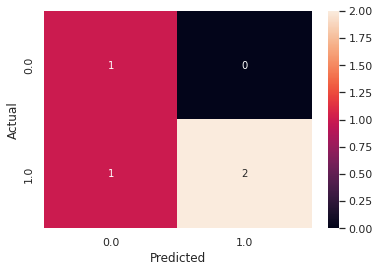

In [67]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [68]:
y_pred

array([0., 0., 1., 1.])

In [69]:
confusion_matrix

Predicted,0.0,1.0
Actual,,
0.0,1,0
1.0,1,2


In [70]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Accuracy:  0.75
